In [1]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice

import math
import sklearn as sk
import xgboost as xg
import statsmodels.tsa.stattools as sm_tools
import statsmodels.tsa.arima_model as stats_arima

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import register_matplotlib_converters

from finance.utilities import utils
from finance.data_science.utilities import financial_utils, time_series_utils

In [2]:
register_matplotlib_converters()

%matplotlib notebook
%matplotlib inline

# Options

In [3]:
_SYMBOL = 'KO'
_DATE = '2020-04-02'

In [4]:
query = f"""
    select *
    from td.equities
    where symbol = '{_SYMBOL}'
        and market_datetime::date = '{_DATE}'
    limit 10
    """
stocks = utils.query_db(query=query)
stocks.head(3).T

,0
symbol,KO
open,42.22
high,44.19
low,41.8623
close,43.95
volume,1.76219e+07
market_datetime_epoch,1585803600000.0
empty,False
market_datetime,2020-04-02 05:00:00
file_datetime,2020-04-19 00:09:51


In [5]:
query = f"""
    with dates as (
        select *
            , file_datetime at time zone 'utc' as _file_datetime
            , extract('hour' from file_datetime at time zone 'utc') _hour
            , extract('month' from file_datetime) _month
            , extract('year' from file_datetime) _year
        from td.options_ko
        ),
    days as (
        select *
            , extract('day' from case when _hour >= 16 then _file_datetime + interval '1 day' else _file_datetime end) as _day
        from dates
        where _hour not between 9 and 16
        ),
    base as (
        select *
            , dense_rank() over (partition by symbol, _year, _month, _day order by file_datetime desc) as dr
            , (_year || '-' || lpad(_month::varchar, '2', '0') || '-' || lpad(_day::varchar, '2', '0'))::date as market_datetime
        from days
        ),
    opts as (
        select
            symbol
            , put_call
            , bid
            , ask
            , (bid + ask) as price
            , total_volume
            , open_interest
            , strike
            , days_to_expiration
            , market_datetime
        from base
        where dr = 1
        )
    select
        c.symbol
        , c.market_datetime
        , c.strike
        , c.days_to_expiration
        , c.bid as call_bid
        , c.ask as call_ask
        , c.price as call_price
        , p.bid as put_bid
        , p.ask as put_ask
        , p.price as put_price
        , c.price - p.price as forward
        , c.price + p.price as cumulative_premium
        , c.price + c.strike as call_breakeven
        , p.price + p.strike as put_breakeven
        , c.total_volume as call_total_volume
        , p.total_volume as put_total_volume
        , c.open_interest as call_open_interest
        , p.open_interest as put_open_interest
    from opts as c
    inner join opts as p
        on c.symbol = p.symbol
        and c.market_datetime = p.market_datetime
        and c.put_call <> p.put_call
        and c.strike = p.strike
        and c.days_to_expiration = p.days_to_expiration
    where c.put_call = 'CALL' and c.market_datetime = '{_DATE}'
    order by c.symbol, c.market_datetime, c.strike, c.days_to_expiration
    """
options = utils.query_db(query=query)
options.head(3).T

,0,1,2
symbol,KO,KO,KO
market_datetime,2020-04-02,2020-04-02,2020-04-02
strike,20,20,20
days_to_expiration,16,23,44
call_bid,19.5,19.5,19.5
call_ask,24.5,24.5,24.15
call_price,44,44,43.65
put_bid,0,0.02,0
put_ask,0.09,0.05,0.37
put_price,0.09,0.07,0.37


### Put call parity

In [6]:
options['r'] = -np.log((options['put_ask'] + stocks['open'].values - options['call_ask'])/options['strike'])/(options['days_to_expiration']/252)

options['call_distance'] = options['call_breakeven'] - stocks['open'].values
options['put_distance'] = stocks['open'].values - options['put_breakeven']
options['percent_call_distance'] = options['call_distance']/stocks['open'].values

options.head()

,symbol,market_datetime,strike,days_to_expiration,call_bid,call_ask,call_price,put_bid,put_ask,put_price,...,call_breakeven,put_breakeven,call_total_volume,put_total_volume,call_open_interest,put_open_interest,r,call_distance,put_distance,percent_call_distance
0,KO,2020-04-02,20.0,16.0,19.5,24.50,44.00,0.00,0.09,0.09,...,64.00,20.09,0.0,0.0,0.0,14.0,1.826562,21.78,22.13,0.515869
1,KO,2020-04-02,20.0,23.0,19.5,24.50,44.00,0.02,0.05,0.07,...,64.00,20.07,0.0,0.0,0.0,0.0,1.295287,21.78,22.15,0.515869
2,KO,2020-04-02,20.0,44.0,19.5,24.15,43.65,0.00,0.37,0.37,...,63.65,20.37,0.0,1.0,0.0,18.0,0.465112,21.43,21.85,0.507579
3,KO,2020-04-02,20.0,79.0,20.7,23.90,44.60,0.03,0.66,0.69,...,64.60,20.69,0.0,0.0,0.0,422.0,0.166979,22.38,21.53,0.530081
4,KO,2020-04-02,20.0,142.0,21.0,23.55,44.55,0.18,0.33,0.51,...,64.55,20.51,0.0,0.0,0.0,0.0,0.091028,22.33,21.71,0.528896


In [7]:
def plot(title, x, y, vline=None, ymin=None, ymax=None, hline=None, xmin=None, xmax=None):
    plt.title(title)
    plt.plot(x, y)
    if vline is not None:
        plt.vlines(
            vline,
            ymin=ymin,
            ymax=ymax,
            colors='r',
            linestyles='dotted'
        )
    if hline is not None:
        plt.hlines(
            hline,
            xmin=xmin,
            xmax=xmax,
            colors='r',
            linestyles='dotted'
        )
    plt.show()

In [13]:
_N_EXPIRATION = 4
_expiration = np.sort(options['days_to_expiration'].unique())[_N_EXPIRATION]
_s = options[options['days_to_expiration'] == _expiration]

_N_STRIKE = 3
_strike = np.sort(options['strike'].unique())[_N_STRIKE]
_e = options[options['strike'] == _strike]

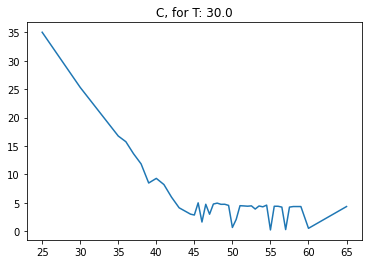

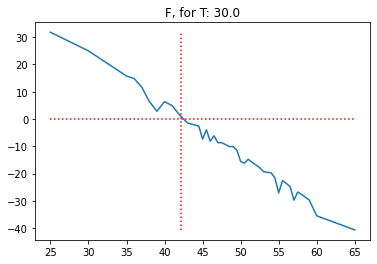

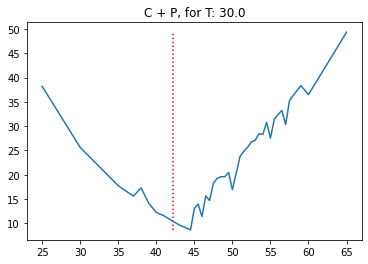

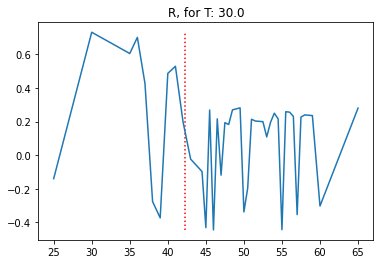

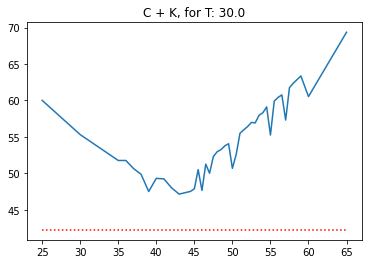

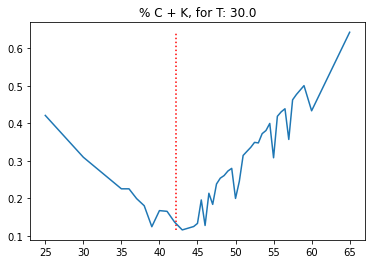

In [42]:
plot(
    title=f'C, for T: {_expiration}',
    x=_s['strike'], 
    y=_s['call_price']
)

plot(
    title=f'F, for T: {_expiration}',
    x=_s['strike'], 
    y=_s['forward'],
    vline=stocks['open'],
    ymin=_s['forward'].min(),
    ymax=_s['forward'].max(),
    hline=0,
    xmin=_s['strike'].min(),
    xmax=_s['strike'].max(),
)

plot(
    title=f'C + P, for T: {_expiration}',
    x=_s['strike'],
    y=_s['cumulative_premium'],
    vline=stocks['open'],
    ymin=_s['cumulative_premium'].min(),
    ymax=_s['cumulative_premium'].max()
)

plot(
    title=f'R, for T: {_expiration}',
    x=_s['strike'],
    y=_s['r'],
    vline=stocks['open'],
    ymin=_s['r'].min(),
    ymax=_s['r'].max()
)

plot(
    title=f'C + K, for T: {_expiration}',
    x=_s['strike'],
    y=_s['call_breakeven'],
    hline=stocks['open'],
    xmin=_s['strike'].min(),
    xmax=_s['strike'].max()
)

plot(
    title=f'% C + K, for T: {_expiration}',
    x=_s['strike'],
    y=_s['percent_call_distance'],
    vline=stocks['open'],
    ymin=_s['percent_call_distance'].min(),
    ymax=_s['percent_call_distance'].max()
)

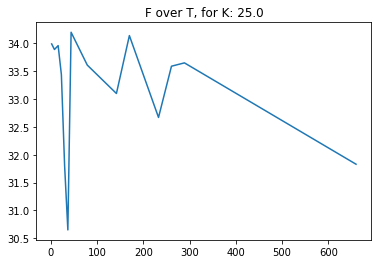

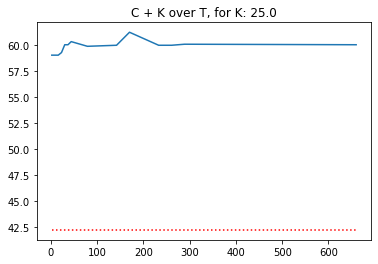

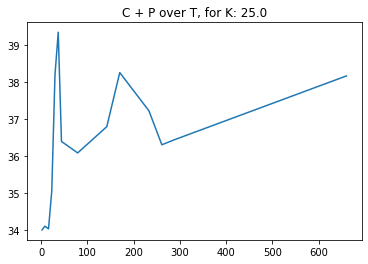

In [15]:
plot(
    title=f'F over T, for K: {_strike}',
    x=_e['days_to_expiration'],
    y=_e['forward']
)

plot(
    title=f'C + K over T, for K: {_strike}',
    x=_e['days_to_expiration'],
    y=_e['call_breakeven'],
    hline=stocks['open'],
    xmin=_e['days_to_expiration'].min(),
    xmax=_e['days_to_expiration'].max()
)

plot(
    title=f'C + P over T, for K: {_strike}',
    x=_e['days_to_expiration'],
    y=_e['cumulative_premium']
)